# Geospatial demand estimation

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]()<br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


In [1]:
# Decide if you want to run a region or the country
area = "COUNTRY"
# area = "Copperbelt" # Regions = Central, Copperbelt, Eastern

### Import necessary modules

In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.geometry import shape, mapping
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
from osgeo import ogr, gdal, osr
import fiona
from rasterstats import zonal_stats
import rasterio
import rasterio.fill
from geojson import Feature, Point, FeatureCollection
import h3 as h3

# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline

In [3]:
# import ipywidgets as widgets
import tkinter as tk
from tkinter import filedialog, messagebox
import datetime
import warnings
import scipy.spatial
warnings.filterwarnings('ignore')

import seaborn as sns

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters, spatialjoinvectors

### Define directories and dataset names

In [5]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs/"

In [6]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

# Part 1. Create base grid with H3

COUNTRY
EPSG:4326


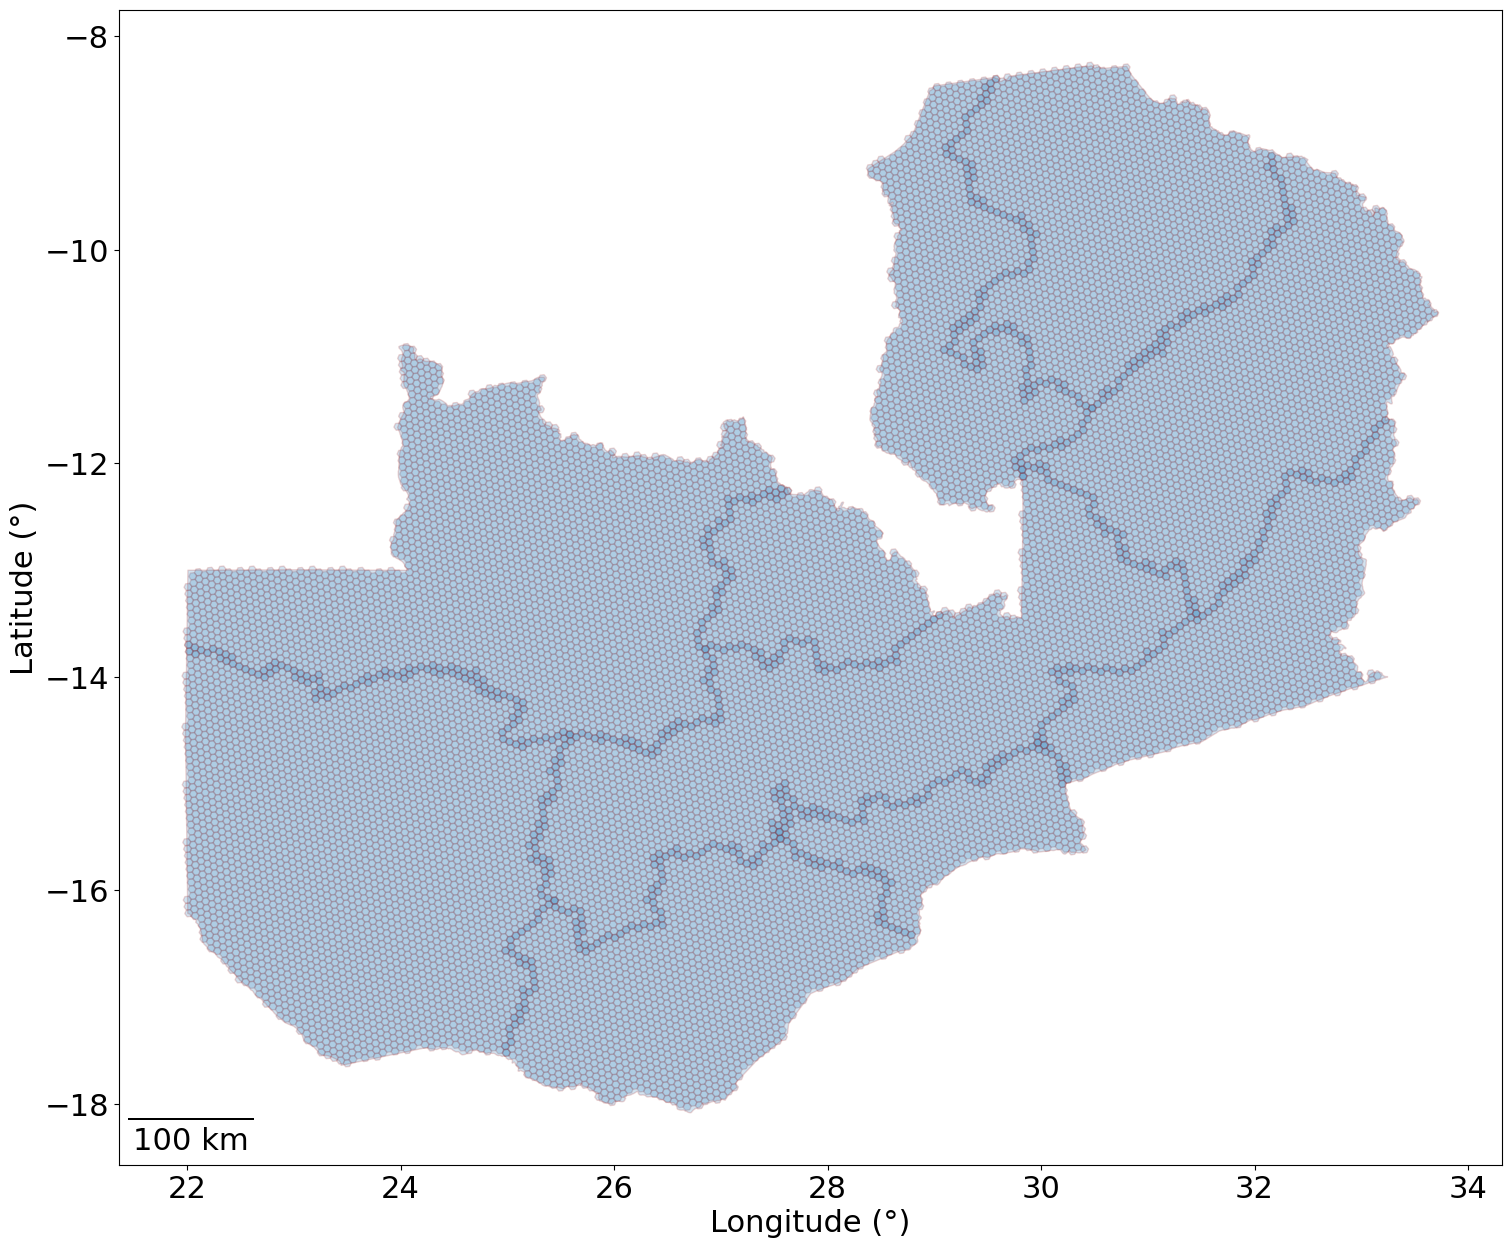

In [7]:
%run BaseGridHex.ipynb

# Part 2. Extract GIS-based attributes

## Extract raster values to hexagons

##### Once done with rasters run this cell

In [8]:
# grid = finalizing_rasters(out_path, grid, crs_proj)

Final dataframe

In [9]:
# grid.drop(['index_right'], axis=1, inplace=True)
# grid.head(4)

## Extract information from vector layers

In [10]:
## admininstrative boundary
admin_path = in_path + "\\"+ 'admin'
admin_name = "gadm41_ZMB.gpkg"      
region_col_name = "NAME_1"   ## Provide the name of the column you want to use to clip the hexagons e.g., "NAME" or "ADM1_NAME"
layer_region_name = "ADM_ADM_1"
layer_admin_name = "ADM_ADM_0"
if area == "COUNTRY":
    admin_gdf = gpd.read_file(admin_path + "/" + admin_name, layer=layer_admin_name)
    region_gdf = gpd.read_file(admin_path + "/" + admin_name, layer=layer_region_name)

In [11]:
# transmission lines
lines_gdf = gpd.read_file(ROOT_DIR + "/Grid/Zambia - HVLines/" + "HVLines.shp")
lines_gdf = gpd.clip(lines_gdf, admin_gdf)

In [12]:
MV_lines_gdf = gpd.read_file(ROOT_DIR + "/Grid/Zambia - MVLines/" + "Zambia - MVLines.shp")
MV_lines_gdf = gpd.clip(MV_lines_gdf, admin_gdf)

In [13]:
MV_O_lines_gdf = gpd.read_file(ROOT_DIR + "/Grid/Zambia - Distribution MV Overhead Line/" + "Zambia - Distribution MV Overhead Line.shp")
MV_O_lines_gdf = gpd.clip(MV_O_lines_gdf, admin_gdf)
MV_U_lines_gdf = gpd.read_file(ROOT_DIR + "/Grid/Zambia - Distribution MV Underground Line/" + "Distribution_Medium_Voltage_Underground_Line_Network_neww.shp")
MV_U_lines_gdf = gpd.clip(MV_U_lines_gdf, admin_gdf)

# Part 3. Constructing Multi-vector Demand

### Calculate Total Demand

**Demand = Residential + Commercial + Industrial **

where, 

**Residential** = No of HH with access X average en. cons. kWh/HH/year X wealth adjustment factor

**Commercial**  = (No of buildings X 20 kWh/bld/year) if more than 100 buildings else (No of buildings X 100 kWh/bld/year)

**Industrial**  = Commodity Production (tonnes) from mines X average energy consumption per tonne

2024-11-21 18:33:45.988615
2024-11-21 18:35:10.847354
2024-11-21 22:50:54.428069
2024-11-21 22:52:26.875842
2024-11-21 22:53:59.716295
2024-11-21 22:55:26.747168
2024-11-21 22:56:51.546433
2024-11-21 22:56:54.625409
-1.1399999856948853
1.3027333577473958
Residential electricity consumption UN stats 4022.5 GWh
services electricity consumption UN STATS: 722 GWh


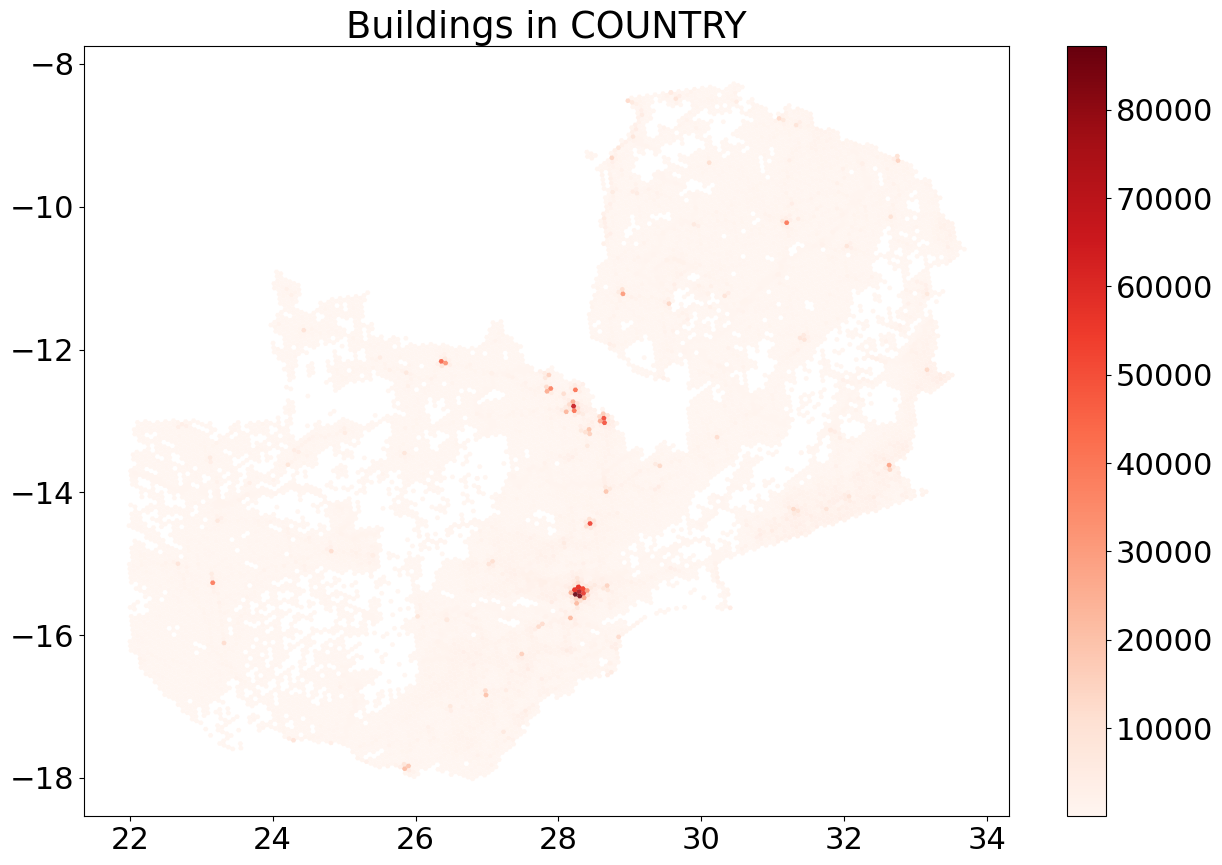

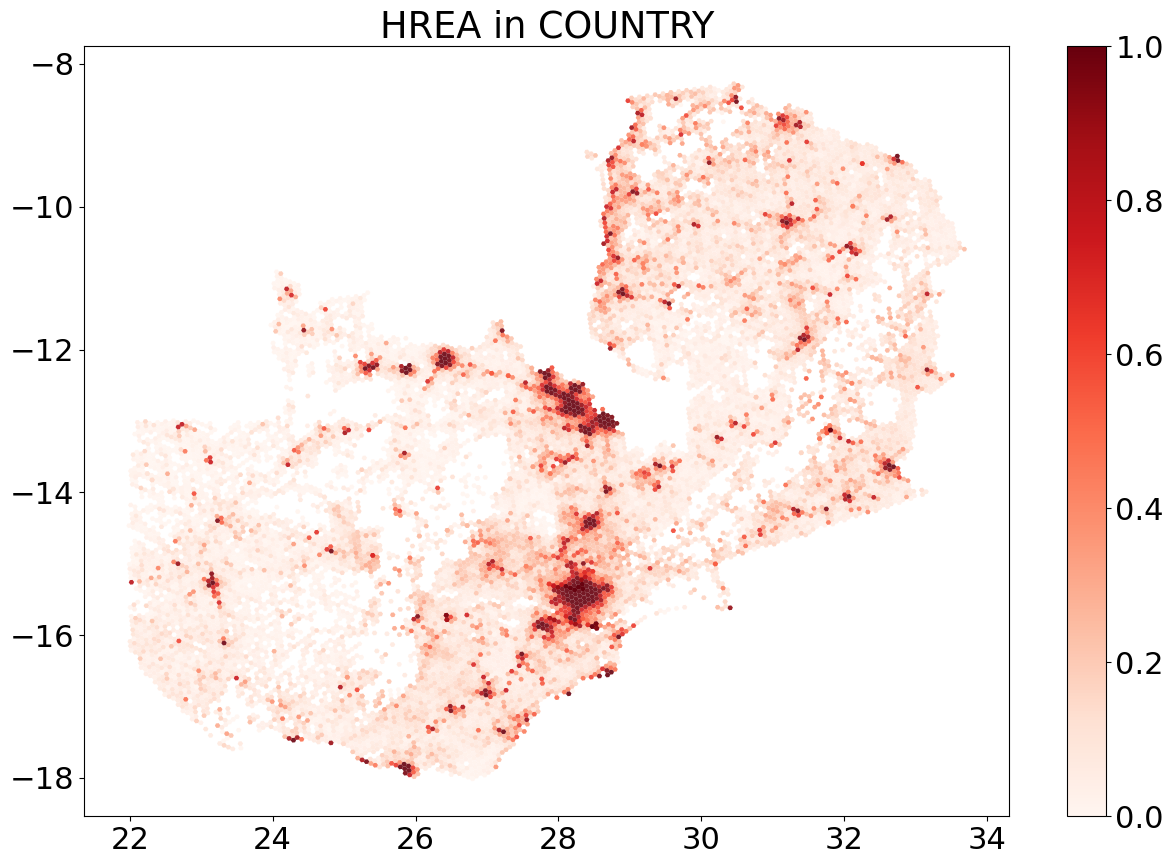

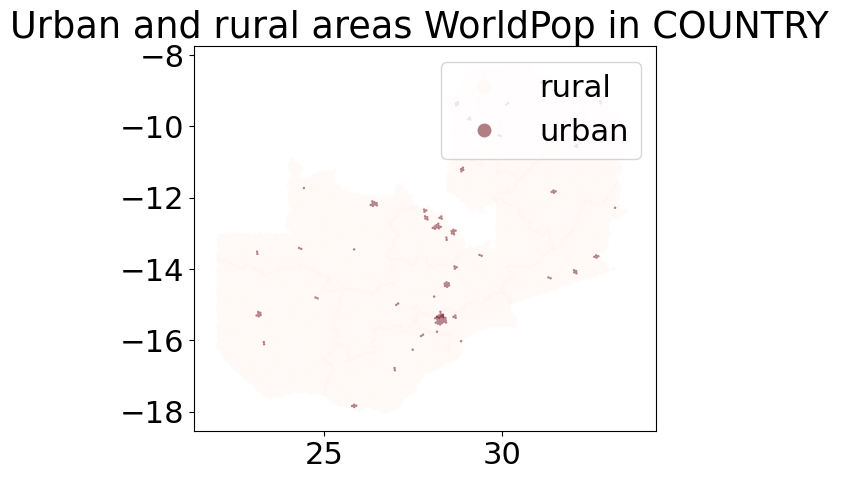

Status_electrified
nonelec    11168
elec        7222
Name: count, dtype: int64
Total population: 17,798,700
Total population: 17,798,700
0
0
1638077.450640989 466820.54935901094 2104898.0 2104898.0
float64 float64 float64
(18390, 41) float64 float64
1638077.450640989
1638077.450640989
Total population with access: 7,979,217
Pop access rate : 45%
Pop access rate urban: 79%
Pop access rate rural: 22%
   Tier 1  Tier 2  Tier 3  Tier 4  Tier 5
0       8     200     778    2224    4656


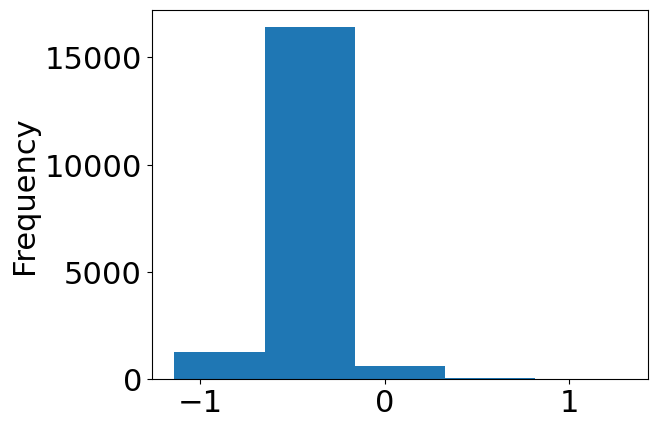

[(np.float64(-1.1399999856948853), 8), (np.float64(-0.651453317006429), 200), (np.float64(-0.16290664831797275), 778), (np.float64(0.32564002037048345), 2224), (np.float64(0.8141866890589398), 4656)]


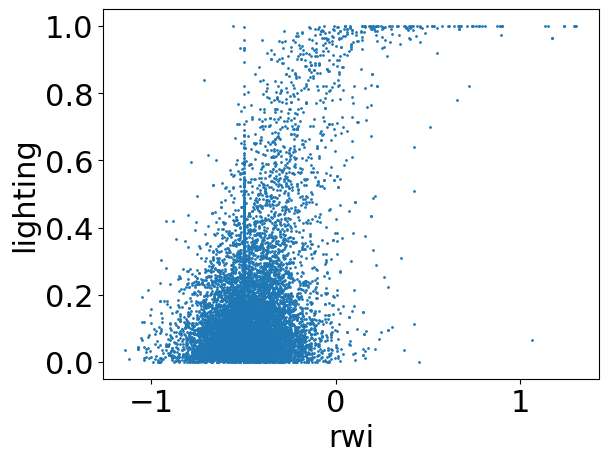

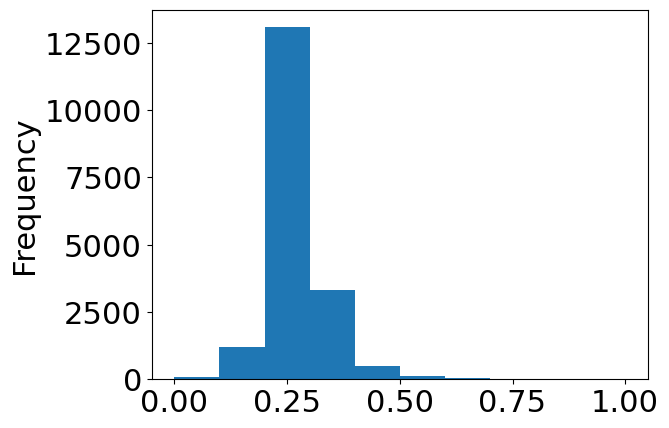

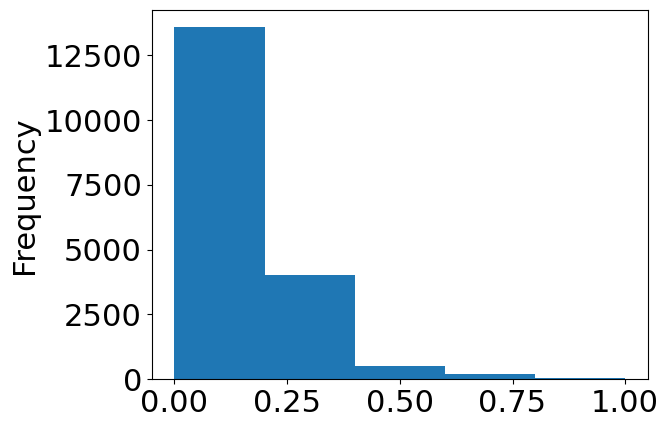

ResEnergyPerHH_index
8       13564
200      4037
778       525
2224      220
4656       44
Name: count, dtype: int64


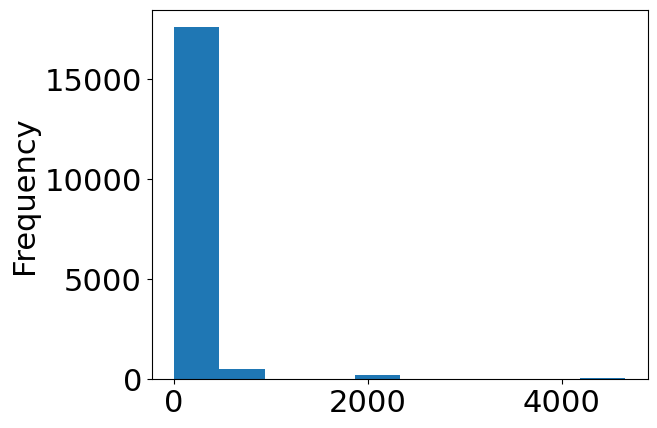

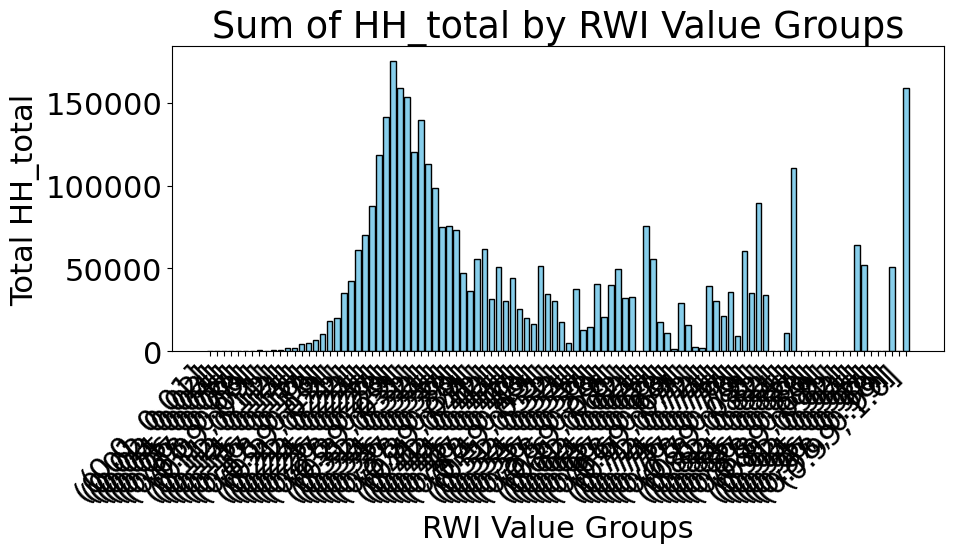

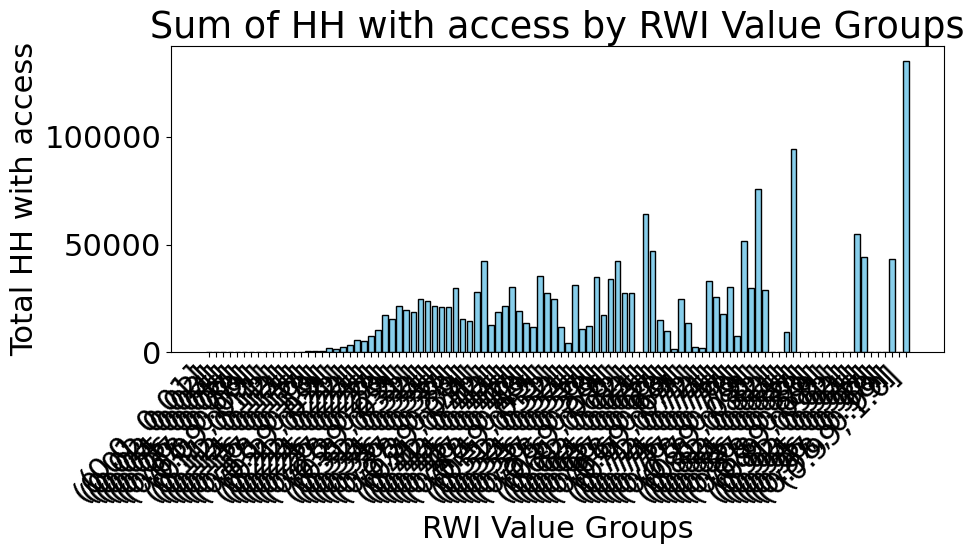

[17.51260392]


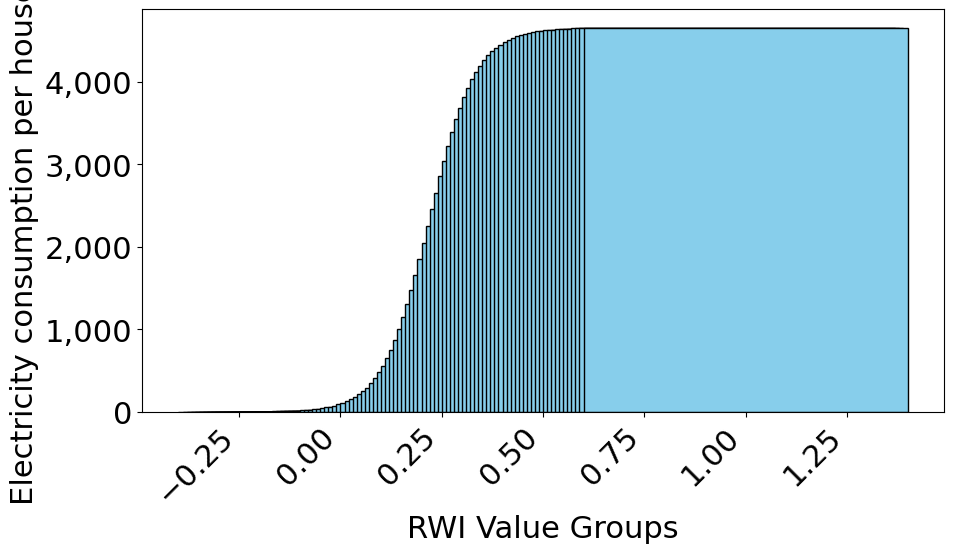

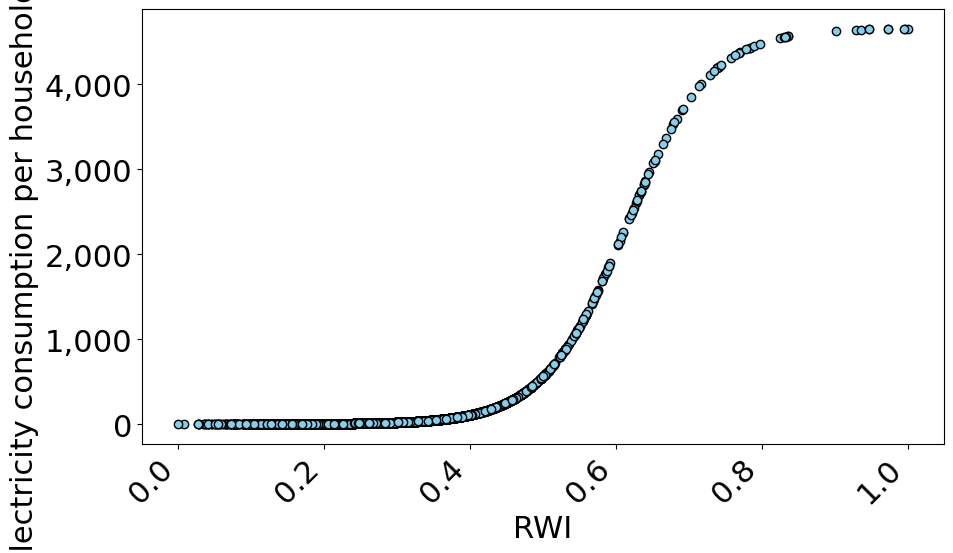

urban total = 2,334 GWh/year
urban average per houshold = 1,882 kWh/year
Created rwi_vs_energy_use_urban.png
rural total = 30 GWh/year
rural average per houshold = 65 kWh/year
Created rwi_vs_energy_use_rural.png
             national  urban  rural
tiers_meth2                        
0                0.54   0.21   0.79
1                0.07   0.00   0.12
2                0.06   0.07   0.05
3                0.04   0.08   0.02
4                0.08   0.18   0.01
5                0.20   0.47   0.00
              national  urban  rural
tiers_meth3a                        
0                 0.53   0.21   0.78
1                 0.13   0.00   0.22
2                 0.00   0.00   0.00
3                 0.06   0.13   0.00
4                 0.28   0.66   0.00
5                 0.00   0.00   0.00
              national  urban  rural
tiers_meth3b                        
0                 0.56   0.21   0.81
1                 0.09   0.00   0.16
2                 0.02   0.00   0.03
3                 0

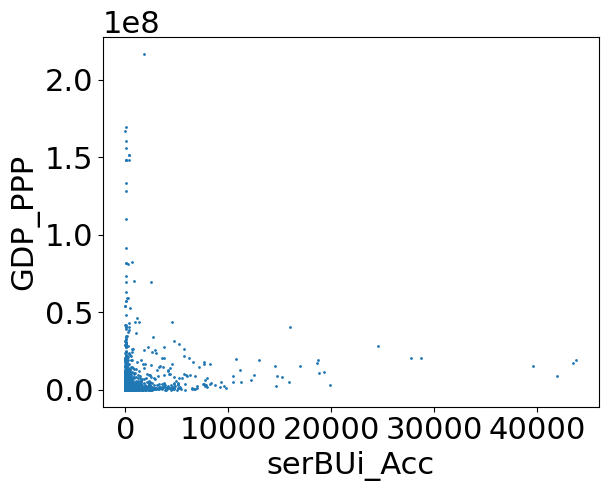

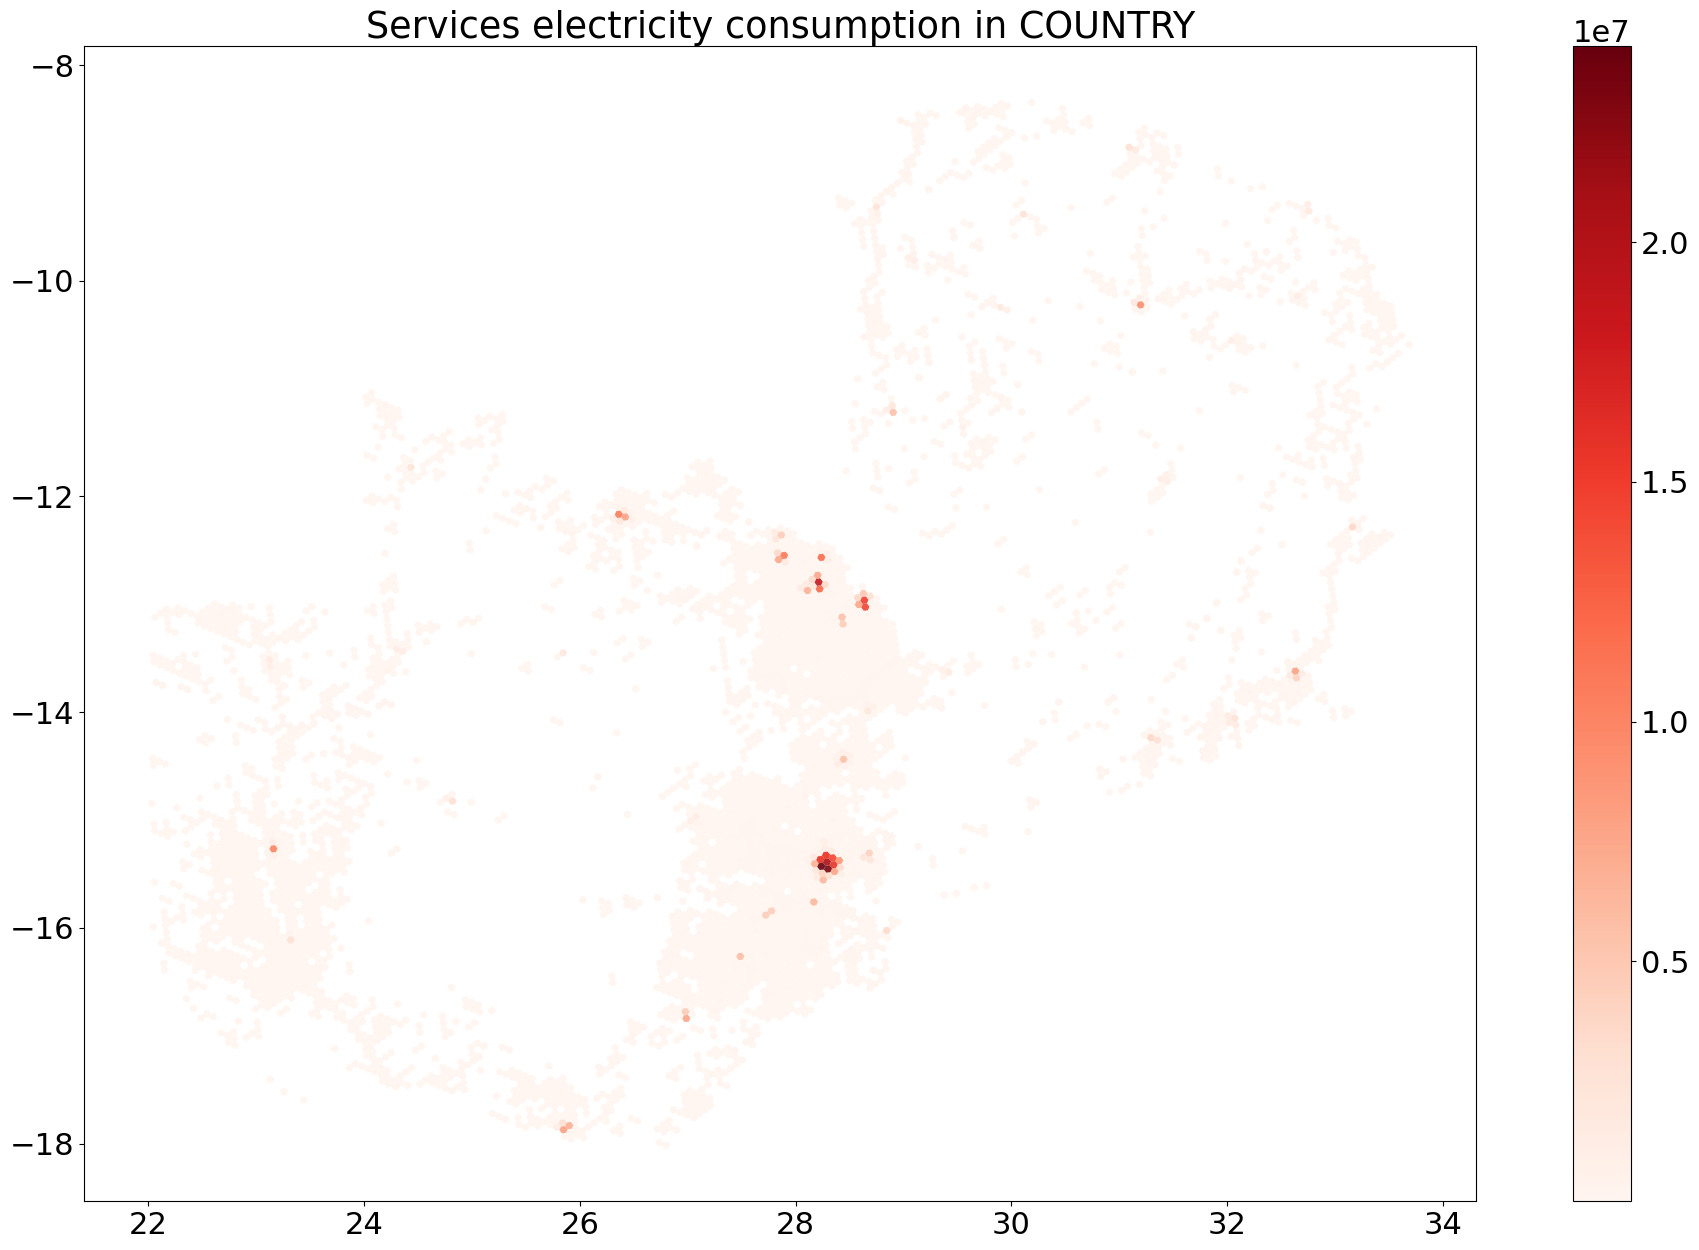

Services electricity consumption assessed after scaling:
Copperbelt 175.9 GWh
Muchinga 14.1 GWh
North-Western 46.0 GWh
Western 31.3 GWh
Luapula 29.0 GWh
Northern 28.9 GWh
Central 60.1 GWh
Southern 74.6 GWh
Eastern 51.3 GWh
Lusaka 210.5 GWh
NAME_1
Central          60.13
Copperbelt      175.86
Eastern          51.28
Luapula          29.00
Lusaka          210.50
Muchinga         14.11
North-Western    45.95
Northern         28.93
Southern         74.63
Western          31.27
Name: SEn_kWh_final, dtype: float64
721.6666666666666
Services electricity consumption assessed after scaling:
Copperbelt 1,409.9 GWh
Muchinga 37.8 GWh
North-Western 217.3 GWh
Western 128.9 GWh
Luapula 96.8 GWh
Northern 151.6 GWh
Central 285.2 GWh
Southern 367.5 GWh
Eastern 170.8 GWh
Lusaka 1,878.4 GWh
NAME_1
Central          285.17
Copperbelt      1409.85
Eastern          170.82
Luapula           96.80
Lusaka          1878.39
Muchinga          37.82
North-Western    217.32
Northern         151.65
Southern         367

In [14]:
%run Residential/BuildingDemandMethod1_Simplified.ipynb


In [15]:
total_residentialenergy_assessed = grid['ResEnergy_kWh_meth3'].sum()
print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh

KeyError: 'ResEnergy_kWh_meth3'

In [ ]:
# grid["Commercial"] = grid.apply(lambda row: (row['buildingscount']*50 if ((row['buildingscount'] > 100))
                                             # else row['buildingscount']*100), axis=1)
# total_servicesenergy_assessed = grid["Commercial"].sum()
# print("services electricity consumption:", f"{total_servicesenergy_assessed/10**6:,.0f}","GWh") # GWh

In [ ]:
%run Industry/IndustryDemand.ipynb
print("Industry electricity consumption in",f"{area}",f"{total_industryenergy/3600:,.1f}", "TWh")

In [ ]:
#Concatenate results
out_path = ROOT_DIR + "/Outputs/"
# gridRes = gpd.read_file(out_path + "res_energy_map.shp")
# gridRes = gpd.read_file(out_path + "ser_energy_map.shp") # contains services and residential data
gridBui = gpd.read_file(out_path + "ser_energy_map.geojson") # contains services and residential data
# gridRes = gridRes.to_crs(crs_proj)
# gridInd = gpd.read_file(out_path + "ind_energy_map.shp")
gridInd = gpd.read_file(out_path + "ind_energy_map.geojson")
# gridInd = gridInd.to_crs(crs_proj)
# init
grid = gridBui.copy()
grid = grid.merge(gridInd, on='id', suffixes=('', '_y'))
# grid = gpd.GeoDataFrame(grid,crs=crs_proj, geometry=grid.geometry)
grid.drop(grid.filter(regex='_y$').columns, axis=1, inplace=True)
# grid = gpd.pd.concat([gridRes, gridInd])
grid.head(4)

In [ ]:
# grid.columns

In [ ]:
#Unit
grid["IndEnergy_GWh"]=grid["IndEne_TJ"]/3600 *10**3
total_ind = grid["IndEnergy_GWh"].sum()
print(f"{total_ind:,.0f}", "GWh")
grid['REnS_GWh'] = grid['ResEnergy_kWh_meth3']/10**6
total_res = grid["REnS_GWh"].sum()
print(f"{total_res:,.0f}", "GWh")
grid['SEn_GWh'] = grid['SEn_kWh_final']/10**6
total_ser = grid["SEn_GWh"].sum()
print(f"{total_ser:,.0f}", "GWh")

In [ ]:
grid["TotalDem"] = grid.apply(lambda row: (np.nansum([row['REnS_GWh'], 
                                          row['SEn_GWh'],  
                                             row["IndEnergy_GWh"]
                                                     ])), axis=1) #sum in GWh

In [ ]:
total = grid["TotalDem"].sum()
print("total electricity consumption:", f"{total:,.0f}","GWh") # GWh

In [ ]:
grid.head(3)

### Export result

In [ ]:
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
grid = grid.to_crs({ 'init': crs_WGS84}) 

In [ ]:
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
    grid.to_file(out_path + 'total_demand_grid.gpkg', driver="GPKG", index=False, engine='fiona')
#grid.to_file(out_path + 'total_demand_grid.geojson', driver="GeoJSON")
grid.to_file(out_path + f'total_demand.geojson', driver='GeoJSON', index=False)  

## Print maps for quick assessment

In [ ]:
plt.rcParams.update({'font.size': 22})

### Total demand map

In [ ]:
# Plot the demand map with use of the full scale
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 15))

# Plot data
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# Save plot as figure 
plt.savefig(out_path +'total_elec_demand_map.png', bbox_inches='tight')

In [ ]:
# Plot the demand map with a threshold value
# Create the axis first
# fig, ax = plt.subplots(figsize=(25, 15))
fig, ax = plt.subplots(figsize=(15, 10))

# Set the threshold
# threshold = np.percentile(npgrid['TotalDem'], 90)
threshold = 0.1 * grid['TotalDem'].max()

# Plot data
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# Save plot as figure 
plt.savefig(out_path +'sample_priority_map_threshold.png', bbox_inches='tight')

In [ ]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['TotalDem'].max()))

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# Save plot as figure 
plt.savefig(out_path +'sample_priority_map_log.png', bbox_inches='tight')

### Residential map

In [ ]:
# Plot the demand map with a log scale value
# Create the axis first
# sns.set_theme('poster')
# sns.set_style('white')
fig, ax = plt.subplots(figsize=(25, 15))

# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Plot data
grid.sort_values('REnS_GWh', ascending=True).plot(
    ax=ax, column='REnS_GWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['REnS_GWh'].max()),
    legend_kwds={"label": "Consumption in GWh"}) #, "orientation": "horizontal"})

admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.4)
# MV_lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.05)

ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity consumption in the residential sector in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity consumption in the residential sector (kWh)' )

# print(grid.crs)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)

ax.add_artist(scalebar)

# Save plot as figure 
plt.savefig(out_path +'map_residential_log.png', bbox_inches='tight')

### Services map

In [ ]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))
# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')


# Plot data
grid.sort_values('SEn_GWh', ascending=True).plot(
    ax=ax, column='SEn_GWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['SEn_GWh'].max()),
    legend_kwds={"label": "Consumption in GWh"})
admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.4)

# # Plot data
# grid.sort_values('TotalDem', ascending=True).plot(
#     ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # Plot data
# grid.sort_values('TotalDem', ascending=True).plot(
#     ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.9)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)
ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity in the services sector in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity in the services sector (GWh)')

ax.add_artist(scalebar)
# Save plot as figure 
plt.savefig(out_path +'map_services_log.png', bbox_inches='tight')

### Buildings map

In [ ]:
grid['Bui_GWh'] = grid['SEn_GWh']+grid['REnS_GWh']

In [ ]:
# Plot the demand map with a log scale value
# Create the axis first
# sns.set_theme('poster')
# sns.set_style('white')
fig, ax = plt.subplots(figsize=(25, 15))
# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')


# Plot data
grid.sort_values('Bui_GWh', ascending=True).plot(
    ax=ax, column='Bui_GWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['Bui_GWh'].max()),
    legend_kwds={"label": "Consumption in GWh"})
admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.4)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)
ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity in buildings in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity in buildings (GWh)')

ax.add_artist(scalebar)
# Save plot as figure 
plt.savefig(out_path +'map_buildings_log.png', bbox_inches='tight')

### Industry map

In [ ]:
# Plot the industry demand map per cell
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data with a log scale value
grid.sort_values('IndEnergy_GWh', ascending=True).plot(
    ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['IndEnergy_GWh'].max()),
    legend_kwds={"label": "Consumption in GWh"})

# # Plot data
# grid.sort_values('IndEnergy_GWh', ascending=True).plot(
#     ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # Plot data
# grid.sort_values('IndEnergy_GWh', ascending=True).plot(
#     ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.9)

admin_gdf.plot(ax=ax, color='None', edgecolor='brown', alpha=0.1)
lines_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in the mining sector in {} (GWh)'.format(area) )

# Save plot as figure 
plt.savefig(out_path +'map_industry_log.png', bbox_inches='tight')

In [ ]:
(grid['IndEnergy_GWh'] != 0).sum()

In [ ]:
(grid['IndEnergy_GWh'] > 50).sum()

In [ ]:
totalperregion=grid.groupby('NAME_1')['IndEnergy_GWh'].sum()
totalperregion

In [ ]:
grid['totalindeperregion'] = grid['NAME_1'].map(totalperregion)

In [ ]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('totalindeperregion', ascending=True).plot(
    ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['totalindeperregion'].max()))

# # Plot data
# grid.sort_values('totalindeperregion', ascending=True).plot(
#     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # Plot data
# grid.sort_values('totalindeperregion', ascending=True).plot(
#     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.9)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.05)
ax.set_aspect('equal', 'box')
ax.set_title('Electricity in the mining sector in Zambia (GWh)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

from matplotlib.ticker import FuncFormatter

# fmt = lambda x, pos: '{:.1%}'.format(x)
# cbar = plt.colorbar(format=FuncFormatter(fmt))

# Save plot as figure 
plt.savefig(out_path +'map_log_ind.png', bbox_inches='tight')